# Bibliotecas

Nesta seção vamos instalar todas as bibliotecas utilizadas.

Além do OpenStreetMap, foram utilizadas: geopandas, pandas e networkx, mas estas já estão disponíveis no jupyter.

In [265]:
!pip install osmnx

Importar todas as bibliotecas necessárias.

In [266]:
from typing import Union

from shapely.geometry import Point, LineString

import pandas as pd
import geopandas as gpd

import folium as fl

import osmnx as ox
import networkx as nx

import matplotlib.pyplot as plt

# Preparação

Nesta seção, vamos preparar o grafo com os dados recolhidos [neste repositório](https://github.com/lemuel-manske/city-block/tree/main/data) e organizar vértices e arestas por bairro.

1. Gerar o grafo composto de Blumenau, Timbó e Indaial (integrantes Lemuel e Lucas são de Blumenau e Rodrigo de Timbó, por isso optamos por manter o vértice em Timbó)

In [267]:
BLUMENAU = 'Blumenau, Brazil'

In [268]:
'''
  Get's graph from a given `place`.
'''
def get_graph_from_place(place: str):
  return ox.graph_from_place(
    place,
    network_type='drive'
  )

In [269]:
'''
  Creates the source graph, composed of all places.
'''
def make_source_graph() -> nx.MultiDiGraph:
  return get_graph_from_place(BLUMENAU)

2. Importar os dados recolhidos para o grafo. Para este processo, foram coletadas longitude - `x` - e latitude - `y` - de cada ponto de interesse e no grafo vamos atribuir um "label" e "nome" para o vértice mais próximo ao ponto de interesse desejado. Todos os datasets estão disponíveis [neste repositório](http://github.com/lemuel-manske/city-block/data)
  - https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.distance.nearest_nodes

In [270]:
ESTUDANTE_TAG = 'estudante'

HOSPITAL_TAG = 'hospital'
CRECHE_TAG = 'creche'
ESCOLA_TAG = 'escola'
PONTO_SAUDE_TAG = 'ponto_saude'
PSICOSSOCIAL_TAG = 'psicossocial'

ALL_SERVICE_TAGS = [
  HOSPITAL_TAG,
  CRECHE_TAG,
  ESCOLA_TAG,
  PONTO_SAUDE_TAG,
  PSICOSSOCIAL_TAG
]

BAIRROS_BLUMENAU_TAG = 'bairros_blumenau'

In [271]:
REPOSITORY = 'https://raw.githubusercontent.com/lemuel-manske/city-block/main/data'

DATASETS = {
    HOSPITAL_TAG: REPOSITORY + '/hospitais.csv',
    ESTUDANTE_TAG: REPOSITORY + '/estudantes.csv',
    CRECHE_TAG: REPOSITORY + '/creches.csv',
    ESCOLA_TAG: REPOSITORY + '/escolas.csv',
    PONTO_SAUDE_TAG: REPOSITORY + '/pontos_saude.csv',
    PSICOSSOCIAL_TAG: REPOSITORY + '/centros_psicossociais.csv',
    BAIRROS_BLUMENAU_TAG: REPOSITORY + '/bairros_blumenau.csv'
}

DATAFRAMES = {
    HOSPITAL_TAG: pd.read_csv(DATASETS[HOSPITAL_TAG]),
    ESTUDANTE_TAG: pd.read_csv(DATASETS[ESTUDANTE_TAG]),
    CRECHE_TAG: pd.read_csv(DATASETS[CRECHE_TAG]),
    ESCOLA_TAG: pd.read_csv(DATASETS[ESCOLA_TAG]),
    PONTO_SAUDE_TAG: pd.read_csv(DATASETS[PONTO_SAUDE_TAG]),
    PSICOSSOCIAL_TAG: pd.read_csv(DATASETS[PSICOSSOCIAL_TAG]),
    BAIRROS_BLUMENAU_TAG: pd.read_csv(DATASETS[BAIRROS_BLUMENAU_TAG])
}

In [272]:
'''
  Loads all `DATAFRAMES` into a graph `G`.

  This function will add nodes for the points for interest (POI) in the graph `G`
  and connect those nodes with their nearest node.
'''
def load_all_data_sets(graph: nx.MultiDiGraph):
  node_id_counter = max(graph.nodes) + 1

  def desserialize(value: str) -> Union[str, bool]:
    if value == 'yes':
      return True

    if value == 'no':
      return False

    return value

  def label_points_of_interest(dataframe: pd.DataFrame, label: str, tags: list[str]):
    nonlocal node_id_counter

    for idx, row in dataframe.iterrows():
      poi_x, poi_y = row['x'], row['y']

      nearest_node = ox.distance.nearest_nodes(graph, X=poi_x, Y=poi_y)

      poi_node_id = node_id_counter
      node_id_counter += 1

      graph.add_node(
        poi_node_id,
        x=poi_x,
        y=poi_y,
        geometry=Point(poi_x, poi_y),
        street_count=0,
        label=label,
        **{tag: desserialize(row[tag]) for tag in tags}
      )

      geometry = LineString([(poi_x, poi_y), (graph.nodes[nearest_node]['x'], graph.nodes[nearest_node]['y'])])

      graph.add_edge(poi_node_id, nearest_node, key=0, geometry=geometry)
      graph.add_edge(nearest_node, poi_node_id, key=0, geometry=geometry)

  def load_data_set(label: str, tags: list[str]):
    label_points_of_interest(DATAFRAMES[label], label, tags)

  load_data_set(ESTUDANTE_TAG,    ['ref', 'student_name'])
  load_data_set(HOSPITAL_TAG,     ['name', 'is_public'])
  load_data_set(CRECHE_TAG,       ['name', 'is_public'])
  load_data_set(ESCOLA_TAG,       ['name', 'is_public'])
  load_data_set(PONTO_SAUDE_TAG,  ['name', 'is_public'])
  load_data_set(PSICOSSOCIAL_TAG, ['name', 'is_public'])

In [273]:
G = make_source_graph()

load_all_data_sets(G)

3. Afim de facilitar a análise, vamos separar todas os vértices e arestas por bairro. Foi necessário remover os bairros que não são reconhecidos na divisão administrativa feita pela prefeitura [neste link](https://www.blumenau.sc.gov.br/secretarias/secretaria-de-desenvolvimento-urbano/pagina/historia-sobre-municipio/divisa-administrativa-bairros) mas que o OSM reconhece.

  - https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.features.features_from_place
  - https://wiki.openstreetmap.org/wiki/Key:admin_level
  - https://www.ibge.gov.br/estatisticas/sociais/saude/22827-censo-demografico-2022.html

In [274]:
'''
  Get's all neighborhoods (idenfied by admin_level 10) on a given place,
  white listing by `places_to_filter`.
'''
def get_neighborhoods(place: str, places_to_filter: list[str]):
  return ox.features.features_from_place(place, {'admin_level': '10'}) \
    .query(f'name in {list(places_to_filter)}')

In [275]:
neighborhoods = get_neighborhoods(BLUMENAU, DATAFRAMES[BAIRROS_BLUMENAU_TAG]['name']) \
  .merge(DATAFRAMES[BAIRROS_BLUMENAU_TAG][['name', 'hab']], on='name', how='left') # `hab` holds population count

4. Com o geopandas, podemos fazer um [*spatial join*](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.sjoin.html#geopandas.GeoDataFrame.sjoin) dos vértices - `G_nodes` - do grafo original que sobrepoem - `predicate='intersects'` - qualquer polígono - `neighborhoods[['geometry']]`. Por fim, renomeamos a coluna de `name_right` para `name` para manter consistência. A saída são todos os vértices de `G`, porém agora estão identificados por bairro num `GeoDataFrame`

 - https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html


In [276]:
def pair_nodes_with_neighborhood_name(graph: nx.MultiDiGraph):
  nodes, _ = ox.graph_to_gdfs(graph)

  return gpd \
    .sjoin(nodes, neighborhoods[['name', 'geometry']], how='left', predicate='intersects') \
    .rename(columns={'name_right': 'name'})['name'] \
    .to_dict()

In [277]:
nx.set_node_attributes(G, pair_nodes_with_neighborhood_name(G), 'neighborhood_name') # adds the new 'neighborhood_name' to G nodes

5. Por fim, definem-se alguams funções utilitárias para facilitar a análise posterior.

In [278]:
'''
  Returns all nodes with a given `label` in a `graph`.
'''
def get_labeled_nodes(label: str, graph: nx.MultiDiGraph = G) -> gpd.GeoDataFrame:
  nodes, _ = ox.graph_to_gdfs(graph)

  return nodes[nodes['label'] == label]

In [279]:
'''
  Get's the node id of a given `student_name`.
'''
def get_student_node_id(student_name: str) -> int:
  students = get_labeled_nodes(ESTUDANTE_TAG)

  student_node = students[students['student_name'] == student_name]

  return student_node.index[0]

In [280]:
'''
  Returns the closest node labelled by `target_service` to a student named `student_name`.
'''
def closest_service_from_student(student_name: str, target_service: str, graph: nx.MultiDiGraph = G) -> int:
  start = get_student_node_id(student_name)

  target_nodes = get_labeled_nodes(target_service)

  curr_path_dist = None

  end_node = None

  for _, hospital in target_nodes.iterrows():
    end = hospital.name

    new_path_dist = nx.dijkstra_path_length(G, start, end)

    if curr_path_dist is None:
      curr_path_dist = new_path_dist
      end_node = end

    elif new_path_dist < curr_path_dist:
      curr_path_dist = new_path_dist
      end_node = end

  return end_node

In [281]:
def center(nodes: gpd.GeoDataFrame):
  return nodes.geometry.union_all().centroid

In [282]:
def get_node_location(node) -> tuple[float, float]:
  return (node['y'], node['x'])

In [283]:
G_nodes, G_edges = ox.graph_to_gdfs(G)

G_center = center(G_nodes)

# Análise

Nesta seção vamos gerar informações a partir dos dados coletados anteriormente.

In [284]:
'''
  Makes a folium map labelling out all points of interest.
'''
def make_map(graph: nx.MultiDiGraph = G):

  def line_off_neighborhoods(m):
    fields = ['name']

    fl.GeoJson(
      neighborhoods.to_json(),
      name='Bairros',
      tooltip=fl.GeoJsonTooltip(labels=False, fields=fields, max_width=100)
    ).add_to(m)


  def mark_out_students(m):
    fields = ['student_name', 'name', 'neighborhood_name']

    marker = fl.Marker(
      icon=fl.Icon(color='blue', icon='home')
    )

    fl.GeoJson(
      get_labeled_nodes(ESTUDANTE_TAG, graph),
      name='Estudantes',
      marker=marker,
      tooltip=fl.GeoJsonTooltip(fields=fields, max_width=100)
    ).add_to(m)


  def mark_out_hospitals(m):
    fields = ['name', 'neighborhood_name']

    marker = fl.Marker(
      icon=fl.Icon(color='red', icon='h-square', prefix='fa')
    )

    hospitals = get_labeled_nodes(HOSPITAL_TAG, graph)

    if hospitals.empty:
      return

    fl.GeoJson(
      hospitals,
      name='Hospitais',
      marker=marker,
      tooltip=fl.GeoJsonTooltip(fields=fields, max_width=100)
    ).add_to(m)


  def mark_out_childcare(m):
    fields = ['name', 'neighborhood_name']

    marker = fl.Marker(
      icon=fl.Icon(color='green', icon='child', prefix='fa')
    )

    fl.GeoJson(
      get_labeled_nodes(CRECHE_TAG, graph),
      name='Creches',
      marker=marker,
      tooltip=fl.GeoJsonTooltip(fields=fields, max_width=100)

    ).add_to(m)


  def mark_out_schools(m):
    fields = ['name', 'neighborhood_name']

    marker = fl.Marker(
      icon=fl.Icon(color='orange', icon='graduation-cap', prefix='fa')
    )

    fl.GeoJson(
      get_labeled_nodes(ESCOLA_TAG, graph),
      name='Escolas',
      marker=marker,
      tooltip=fl.GeoJsonTooltip(fields=fields, max_width=100)
    ).add_to(m)


  def mark_out_psychosocial_care(m):
    fields = ['name', 'neighborhood_name']

    marker = fl.Marker(
      icon=fl.Icon(color='purple', icon='user-md', prefix='fa')
    )

    fl.GeoJson(
      get_labeled_nodes(PSICOSSOCIAL_TAG, graph),
      name='Centros psicossociais',
      marker=marker,
      tooltip=fl.GeoJsonTooltip(fields=fields, max_width=100)
    ).add_to(m)


  def mark_out_points_of_care(m):
    fields = ['name', 'neighborhood_name']

    marker = fl.Marker(
      icon=fl.Icon(color='gray', icon='medkit', prefix='fa')
    )

    fl.GeoJson(
      get_labeled_nodes(PONTO_SAUDE_TAG, graph),
      name='Pontos de saúde',
      marker=marker,
      tooltip=fl.GeoJsonTooltip(fields=fields, max_width=100)
    ).add_to(m)

  nodes, edges = ox.graph_to_gdfs(graph)

  c = center(nodes)

  map = fl.Map(location=[c.y, c.x], zoom_start=14)

  line_off_neighborhoods(map)

  mark_out_students(map)
  mark_out_hospitals(map)
  mark_out_childcare(map)
  mark_out_schools(map)
  mark_out_psychosocial_care(map)
  mark_out_points_of_care(map)

  return map

1. Utilizando `folium` é gerado um mapa interativo que inclui todos os [serviços públicos recolhidos](http://github.com/lemuel-manske/city-block/blob/main/data) e ponto de referência para a residência dos integrantes. O mapa possui divisão por bairros. Utilize o `Layer Control` no canto superior direito do mapa para interagir com as camadas.

In [285]:
m = make_map(G)

fl.LayerControl() \
  .add_to(m)

m

In [286]:
def make_radius(
    graph: nx.MultiDiGraph,
    source_node_id: int,
    radiuses: dict[int, str]):
  map = make_map(graph)

  source_node = graph.nodes[source_node_id]

  for r in radiuses:
    r_name = f'{r} metros'

    group = fl.FeatureGroup(r_name)

    fl.Circle(
      location=get_node_location(source_node),
      radius=r,
      weight=0,
      fill_opacity=0.25,
      opacity=1,
      fill_color=radiuses[r],
      fill=False,
      tooltip=r_name
    ).add_to(group)

    group.add_to(map)

  return map

2. Ainda é possível delimitar os serviços disponíveis num raio desejado. Como exemplo, partindo o ponto de referência `lemuel` geramos uma cobertura de 1, 5 e 10 km.

In [292]:
distances = [
    1000,
    5000,
    10000
]

In [295]:
student_name = 'lemuel'

data = []

for service in ALL_SERVICE_TAGS:
  service_data = {
    'student_name': student_name,
    'service_name': service
  }

  student_node_id = get_student_node_id(student_name)

  service_nodes = get_labeled_nodes(service)

  for distance in distances:
    count = 0

    for _, node in service_nodes.iterrows():
      target_node_id = node.name

      try:
        dist = nx.shortest_path_length(G, source=student_node_id, target=target_node_id, weight='length')

        if dist <= distance:
          count += 1
      except nx.NetworkXNoPath:
        pass

    service_data[f'{distance}_m'] = count

  data.append(service_data)

df_nearby_services = pd.DataFrame(data)

df_nearby_services

,student_name,service_name,1000_m,5000_m,10000_m
0,lemuel,hospital,0,0,4
1,lemuel,creche,0,17,43
2,lemuel,escola,0,21,86
3,lemuel,ponto_saude,0,13,29
4,lemuel,psicossocial,0,2,6


In [294]:
lemuel = get_student_node_id('lemuel')

colors = [ 'red', 'blue', 'orange' ]

m = make_radius(G, lemuel, dict(zip(distances, colors)))

fl.LayerControl() \
  .add_to(m)

m

Serviços por bairro:

In [288]:
def count_services_by_neighborhood(graph: nx.MultiDiGraph = G):
  service_counts = {}

  for service_tag in ALL_SERVICE_TAGS:
    labeled_nodes = get_labeled_nodes(service_tag, graph)

    service_counts[service_tag] = labeled_nodes.groupby('neighborhood_name') \
      .size() \
      .reset_index(name='count')

  return service_counts

In [289]:
service_counts = count_services_by_neighborhood(G)

In [290]:
all_service_counts_df = pd.concat([
  df.set_index('neighborhood_name') for df in service_counts.values()
], axis=1) \
  .fillna(0) \
  .astype(int)

all_service_counts_df.columns = ALL_SERVICE_TAGS

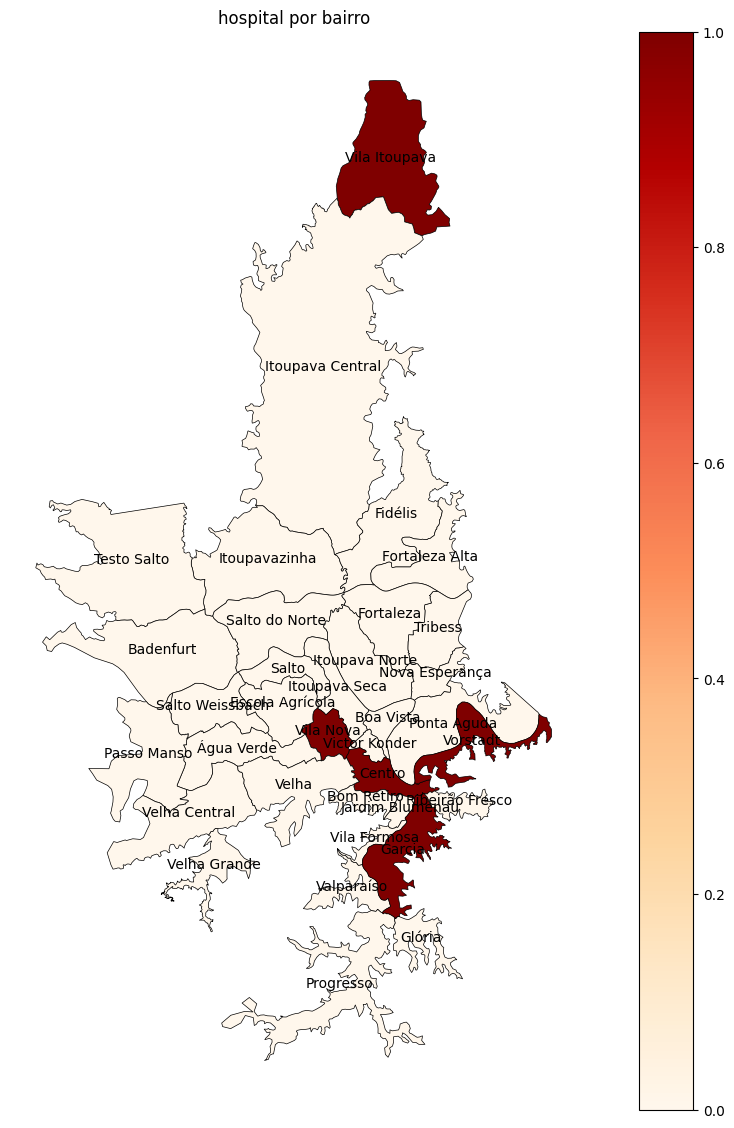

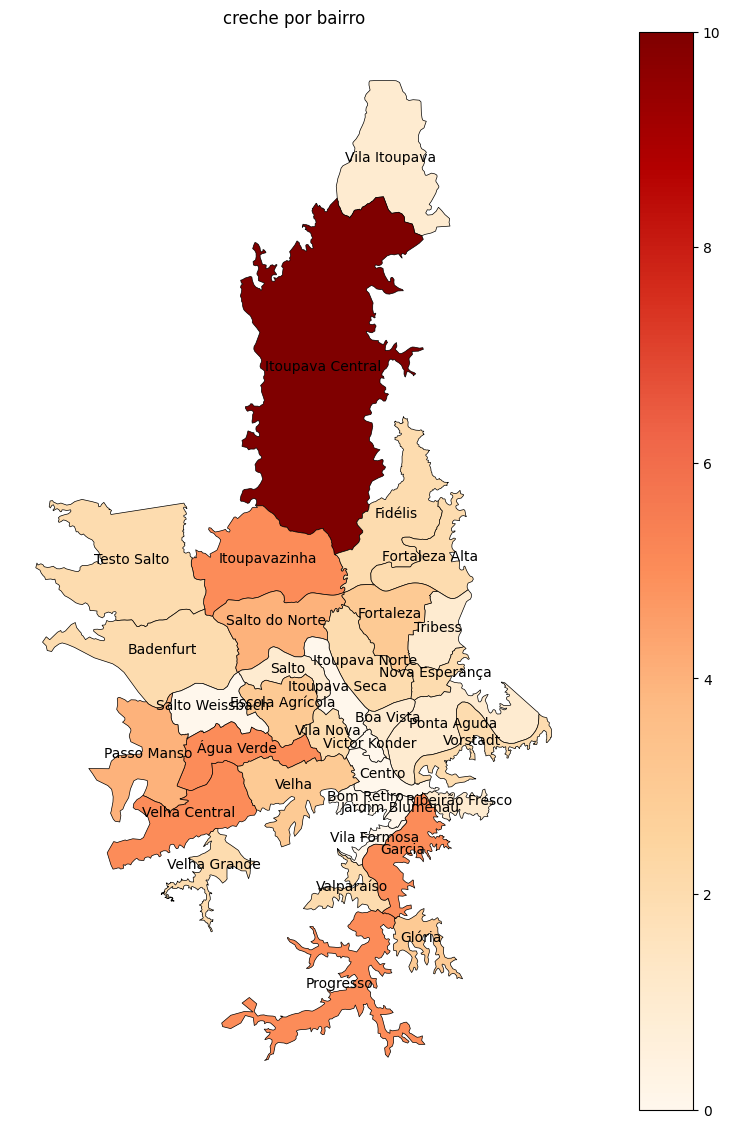

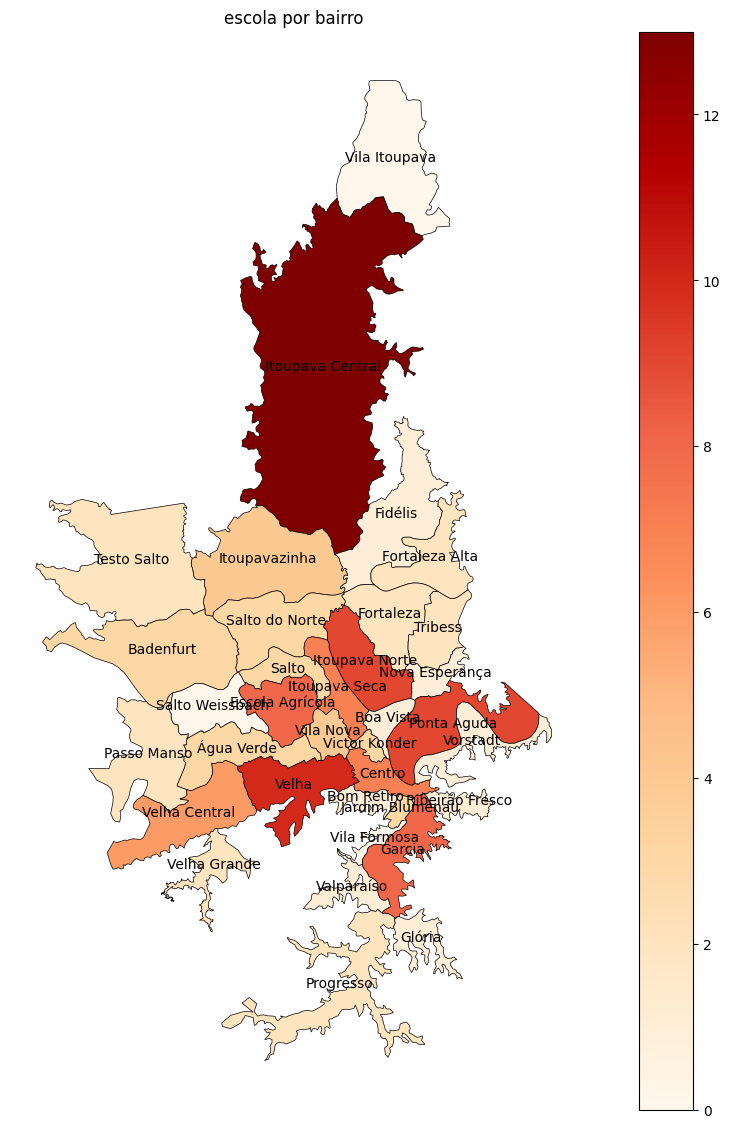

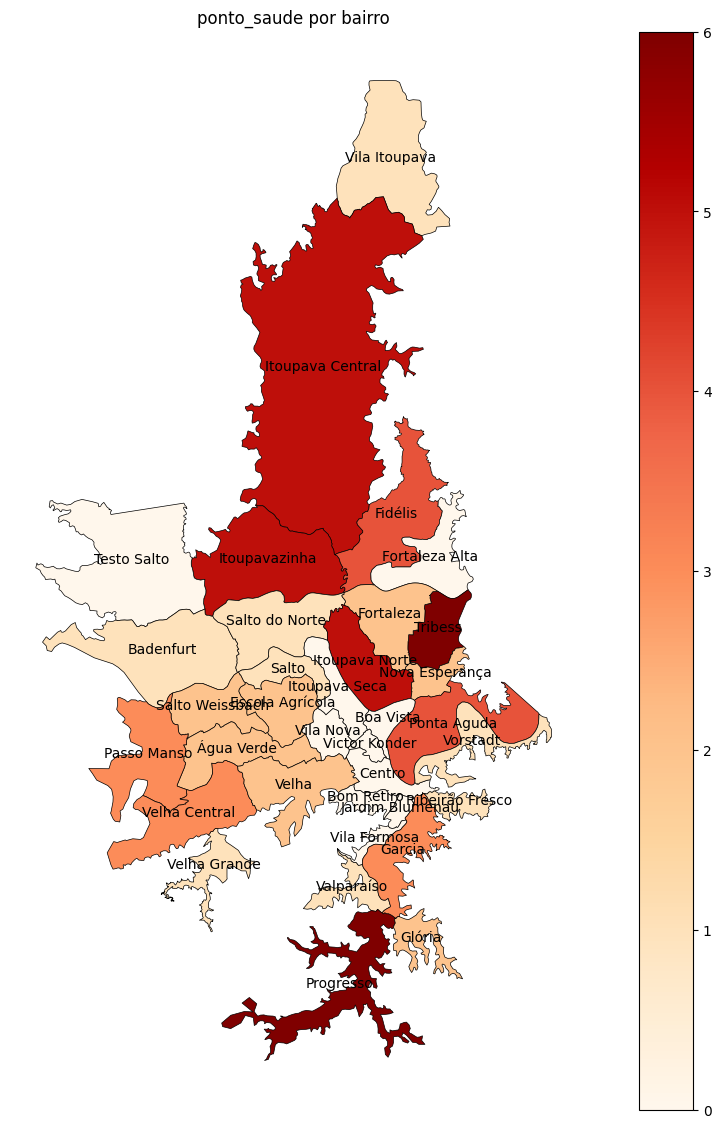

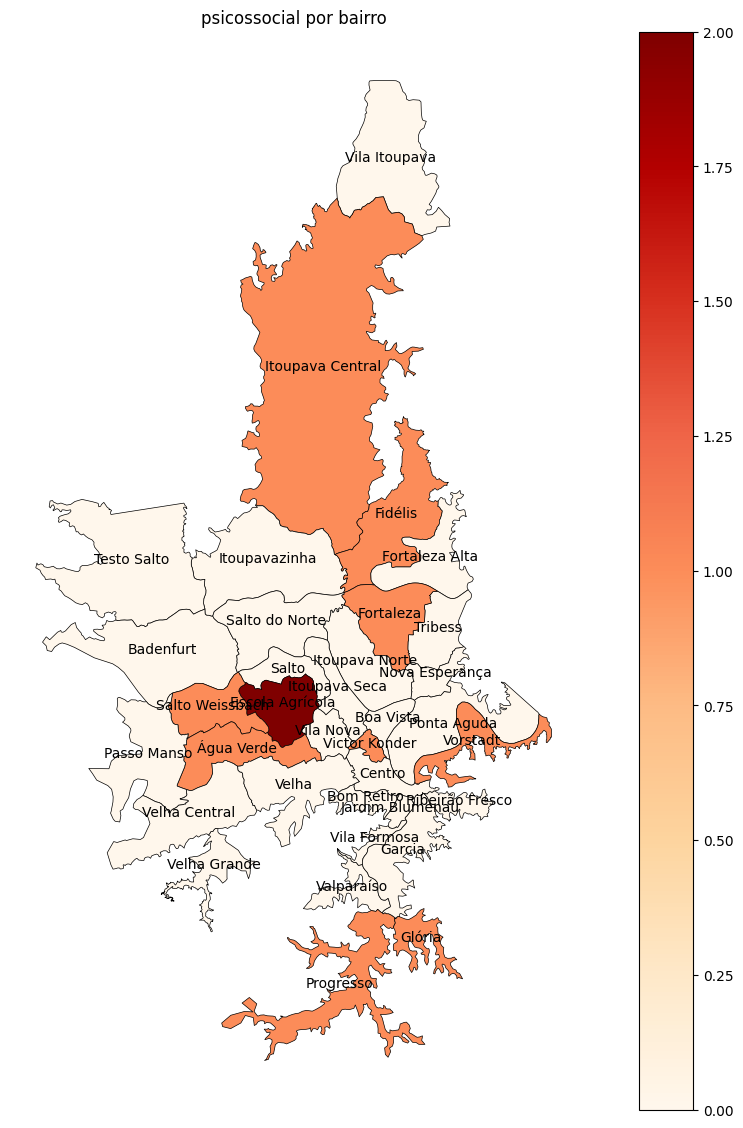

In [291]:
for service_tag in ALL_SERVICE_TAGS:
  if service_counts[service_tag] is None or service_counts[service_tag].empty:
    break

  neighborhoods_with_counts = neighborhoods \
    .merge(service_counts[service_tag], left_on='name', right_on='neighborhood_name', how='left')

  neighborhoods_with_counts['count'] = neighborhoods_with_counts['count'] \
    .fillna(0)

  fig, ax = plt.subplots(1, 1, figsize=(16, 14))

  neighborhoods_with_counts.plot(
    ax=ax,
    column='count',

    legend=True,
    cmap='OrRd',

    edgecolor='black',
    linewidth=0.5,

    legend_kwds={ 'orientation': 'vertical' }
  )

  neighborhoods_with_counts.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

  ax.axis('off')
  ax.set_title(f'{service_tag} por bairro')

  plt.show()
  print('\n')